# Traffic Light Classifier

This traffic ligh classifier was trained using the [SSD Inception V2 model](https://arxiv.org/pdf/1512.00567v3.pdf). 

This notebook was adapted from material in the [Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start. I used [coldKnight's labeled dataset](https://github.com/coldKnight/TrafficLight_Detection-TensorFlowAPI#get-the-dataset) for training and [Alex Lechler's labeled dataset](https://github.com/alex-lechner/Traffic-Light-Classification) for testing.

# Imports

In [73]:
from glob import glob
import numpy as np
import os
import random
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ != '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.0!')


## Env setup

In [74]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [75]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

In [76]:
# Type of graph to load, uncomment either 'sim' or 'real' to validate 
# WORLD_TYPE = 'sim'
WORLD_TYPE = 'real'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = r'models/{}/frozen_inference_graph.pb'.format(WORLD_TYPE)
    
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = r'data/label_map.pbtxt'

NUM_CLASSES = 13

if WORLD_TYPE == 'sim':
    TEST_IMAGE_PATHS = glob(r'data/sim_test_data/**/*.jpg')
elif WORLD_TYPE == 'real':
    TEST_IMAGE_PATHS = glob(r'data/real_test_data/*.jpg')
else:
    print('set WORLD_TYPE to sim or real')

## Load a frozen Tensorflow model into memory.

In [77]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `3`, we know that this corresponds to `Yellow`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [78]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [79]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [80]:
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

Image:  data/real_test_data\left1085.jpg
Score   Class
0.99894 Green
0.00217 Green
0.00214 off
0.00178 off
0.00172 off
0.00170 off
0.00158 Yellow
0.00150 off
0.00150 off
0.00149 off


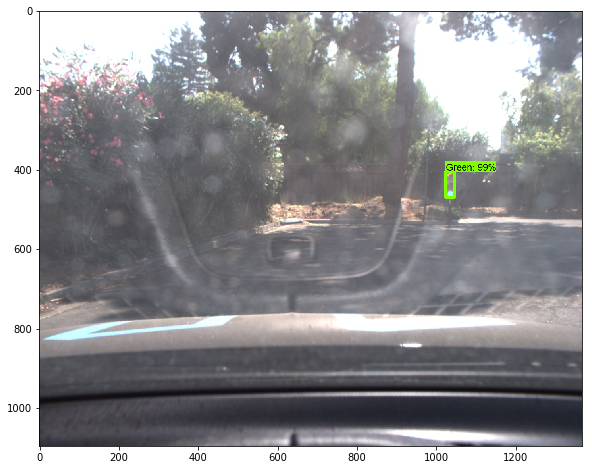

Image:  data/real_test_data\left1078.jpg
Score   Class
0.99834 Green
0.00442 Red
0.00288 Red
0.00211 Red
0.00207 off
0.00199 Red
0.00196 Yellow
0.00184 off
0.00174 Yellow
0.00168 Red


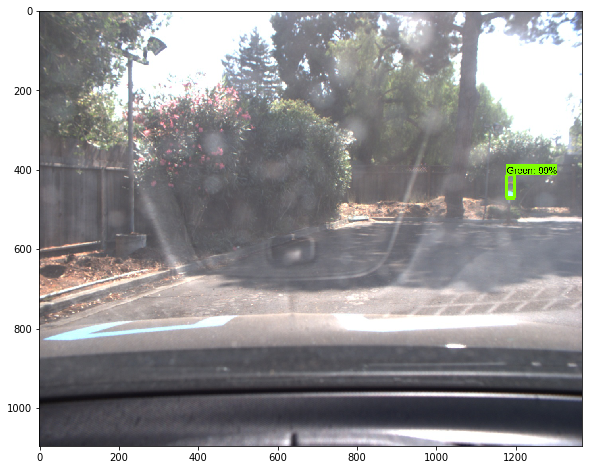

Image:  data/real_test_data\left0893.jpg
Score   Class
0.86566 Yellow
0.07028 Green
0.00844 Red
0.00398 Yellow
0.00322 off
0.00253 off
0.00249 off
0.00216 off
0.00212 off
0.00210 Yellow


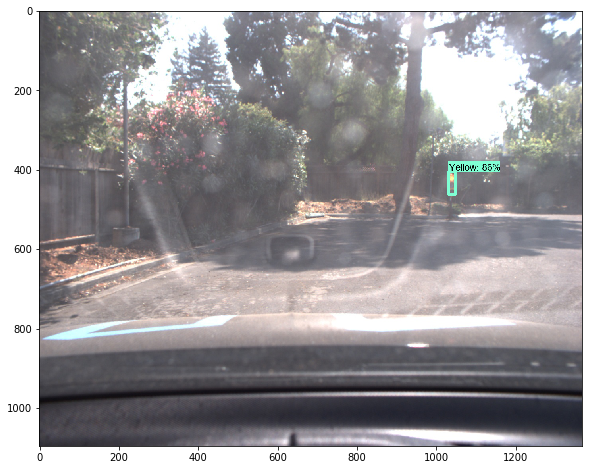

Image:  data/real_test_data\left0719.jpg
Score   Class
0.98790 Red
0.00918 Green
0.00242 Green
0.00206 off
0.00203 off
0.00198 Yellow
0.00189 Green
0.00189 off
0.00188 off
0.00185 off


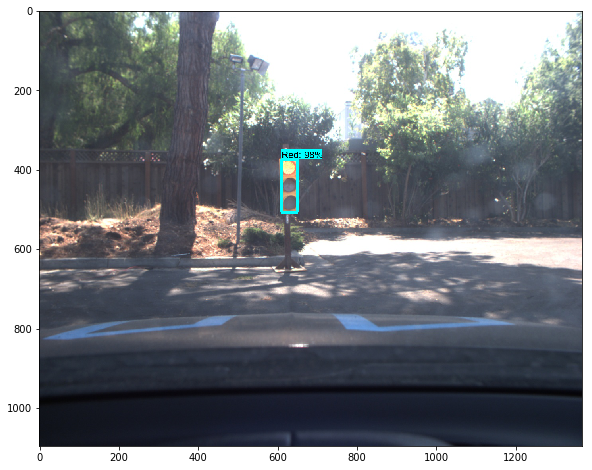

Image:  data/real_test_data\left0736.jpg
Score   Class
0.42136 Green
0.00369 Green
0.00314 Green
0.00301 Green
0.00297 off
0.00270 Red
0.00226 off
0.00218 Yellow
0.00214 Yellow
0.00210 Yellow


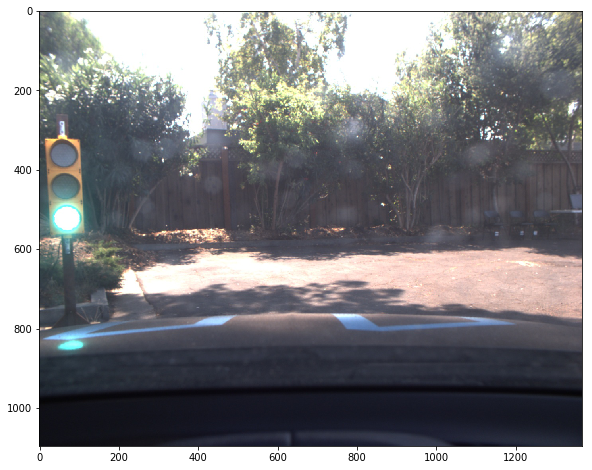

Image:  data/real_test_data\left0675.jpg
Score   Class
0.54520 Yellow
0.08373 Green
0.00903 Green
0.00327 off
0.00317 Red
0.00307 Green
0.00298 off
0.00267 off
0.00266 off
0.00245 Green


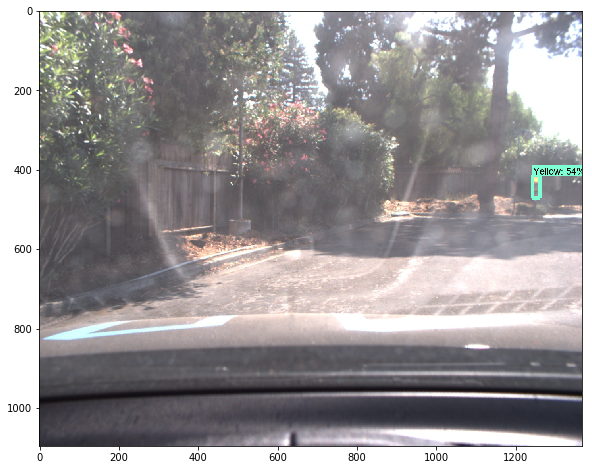

Image:  data/real_test_data\left0715.jpg
Score   Class
0.40594 Red
0.01684 Green
0.00367 Yellow
0.00281 Yellow
0.00235 off
0.00234 off
0.00228 Green
0.00223 off
0.00218 off
0.00214 Yellow


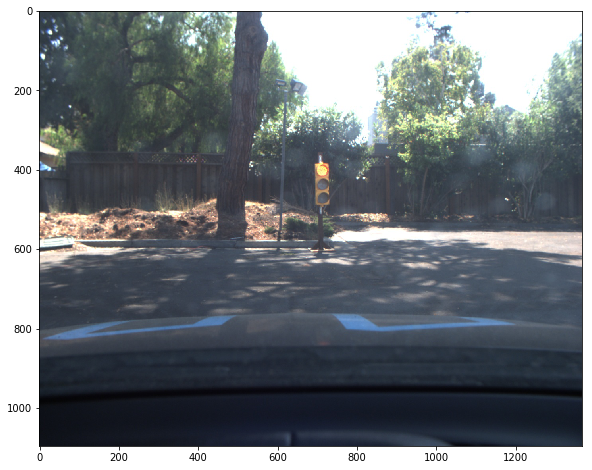

Image:  data/real_test_data\left0698.jpg
Score   Class
0.84814 Red
0.01894 Yellow
0.01083 Green
0.00305 Red
0.00202 Red
0.00200 Yellow
0.00194 Red
0.00184 Red
0.00181 off
0.00178 Green


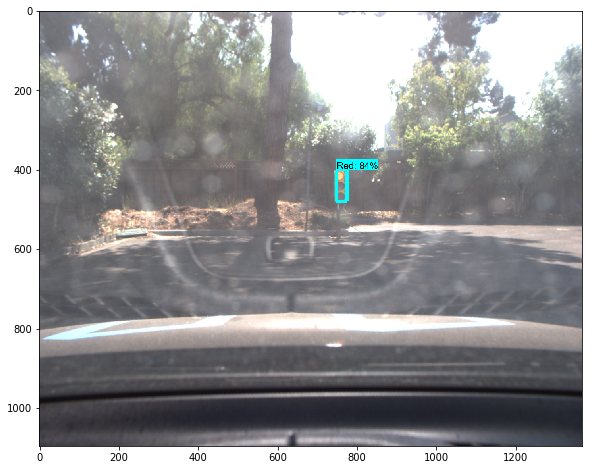

In [89]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
    random.shuffle(TEST_IMAGE_PATHS)
        
    for i, image_path in enumerate(TEST_IMAGE_PATHS):
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)        
        
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        
        print('Image:  {}'.format(image_path))
        print('Score   Class')
        for j in range(len(scores[0])):
            print('{:.5f} {}'.format(scores[0][j], category_index[classes[0][j]]['name']))

        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        plt.show()
        
        if i == 7:
            break